In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import logging
import string
import sys

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dask.distributed import Client
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import \
    estimate_movement_var

from src.figure_utilities import (PAGE_HEIGHT, TWO_COLUMN, save_figure,
                                  set_figure_defaults)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY

set_figure_defaults()

In [3]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import \
    estimate_movement_var
from src.sorted_spikes_simulation import (make_continuous_replay,
                                          make_fragmented_continuous_fragmented_replay,
                                          make_fragmented_hover_fragmented_replay,
                                          make_fragmented_replay,
                                          make_hover_continuous_hover_replay,
                                          make_hover_replay,
                                          make_simulated_run_data)

client = Client(processes=True, n_workers=10)

(time, linear_distance, sampling_frequency,
 spikes, place_fields) = make_simulated_run_data()

movement_var = estimate_movement_var(linear_distance, sampling_frequency)

classifier = SortedSpikesClassifier(movement_var=movement_var,
                                    replay_speed=120,
                                    spike_model_penalty=0.5,
                                    place_bin_size=np.sqrt(movement_var))
classifier.fit(linear_distance, spikes)

SortedSpikesClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                     'identity'],
                                                    ['uniform', 'uniform',
                                                     'uniform'],
                                                    ['random_walk', 'uniform',
                                                     'identity']],
                       discrete_transition_diag=0.99,
                       discrete_transition_type='strong_diagonal',
                       infer_track_interior=True,
                       initial_conditions_type='uniform_on_track',
                       knot_spacing=10, movement_var=0.2775841643294236,
                       place_bin_size=0.5268625668325884, position_range=None,
                       replay_speed=120, spike_model_penalty=0.5)

In [68]:
from src.sorted_spikes_simulation import make_hover_continuous_fragmented_replay
from src.parameters import STATE_ORDER, STATE_COLORS, TRANSITION_TO_CATEGORY

replay_time, test_spikes = make_hover_continuous_fragmented_replay()
replay_time *= 1000
results = (
    classifier.predict(test_spikes, time=replay_time)
    .assign_coords(state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)))
results

<xarray.Dataset>
Dimensions:            (position: 342, state: 3, time: 180)
Coordinates:
  * time               (time) float64 0.0 1.0 2.0 3.0 ... 177.0 178.0 179.0
  * position           (position) float64 0.2632 0.7895 1.316 ... 179.2 179.7
  * state              (state) object 'Continuous' 'Fragmented' 'Hover'
Data variables:
    likelihood         (time, state, position) float64 0.2457 0.274 ... 0.001209
    causal_posterior   (time, state, position) float64 0.003117 ... 4.64e-07
    acausal_posterior  (time, state, position) float64 0.0001789 ... 4.64e-07

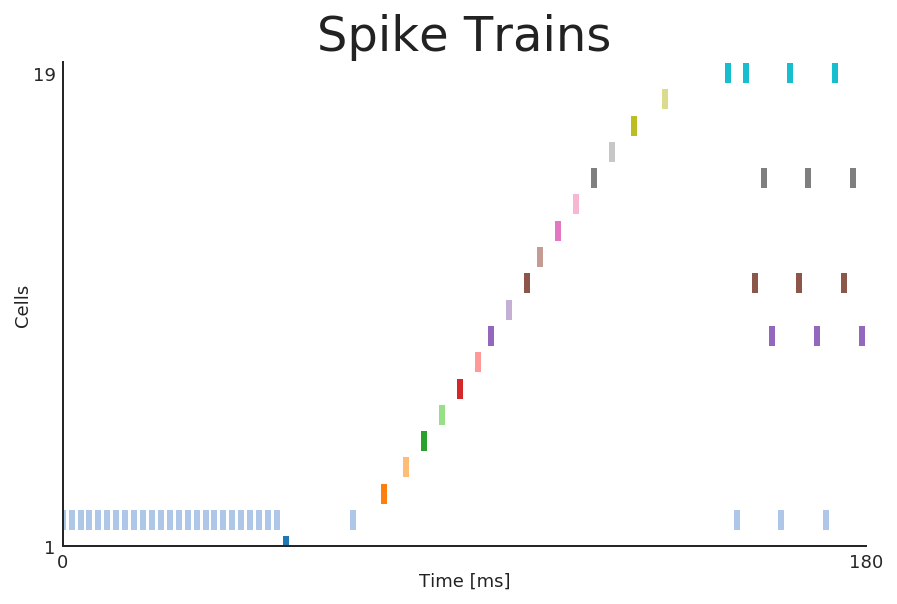

In [69]:
fig, ax = plt.subplots()

spike_ind, neuron_ind = np.nonzero(test_spikes)
cmap = plt.get_cmap('tab20')

c = [cmap.colors[ind] for ind in neuron_ind]
ax.scatter(replay_time[spike_ind], neuron_ind + 1, c=c, marker='|', s=100, linewidth=3)
ax.set_yticks((1, spikes.shape[1]))
ax.set_ylabel('Cells')
ax.set_ylim((1, test_spikes.shape[1]+0.4))
ax.set_xlabel('Time [ms]')
ax.set_xlim((replay_time.min(), replay_time.max() + 1))
ax.set_xticks((replay_time.min(), replay_time.max() + 1))
ax.set_title('Spike Trains', fontsize=24)
sns.despine()

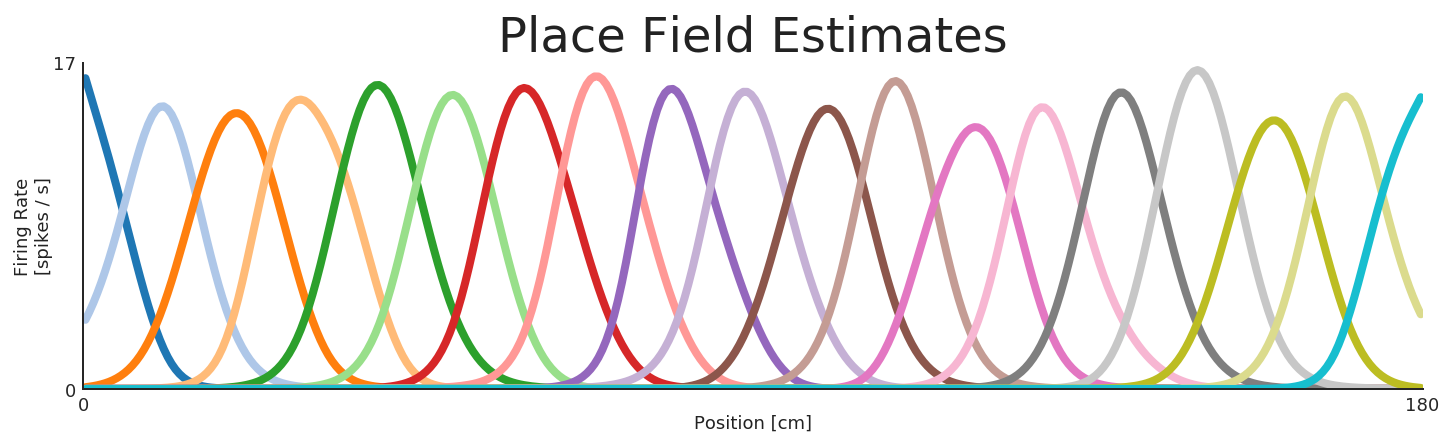

In [70]:
fig, ax = plt.subplots(figsize=(12, 3))


for place_field, color in zip(classifier.place_fields_.T, cmap.colors):
    ax.plot(classifier.place_bin_centers_, place_field * 1000, linewidth=4, color=color)

ax.set_ylabel('Firing Rate\n[spikes / s]')
ax.set_ylim([0, np.ceil(classifier.place_fields_.max() * 1000)])
ax.set_yticks([0, np.ceil(classifier.place_fields_.max() * 1000)])


ax.set_xlabel('Position [cm]')
ax.set_xlim((linear_distance.min(), linear_distance.max()))
ax.set_xticks((linear_distance.min(), linear_distance.max()))


ax.set_title('Place Field Estimates', fontsize=24)

sns.despine()

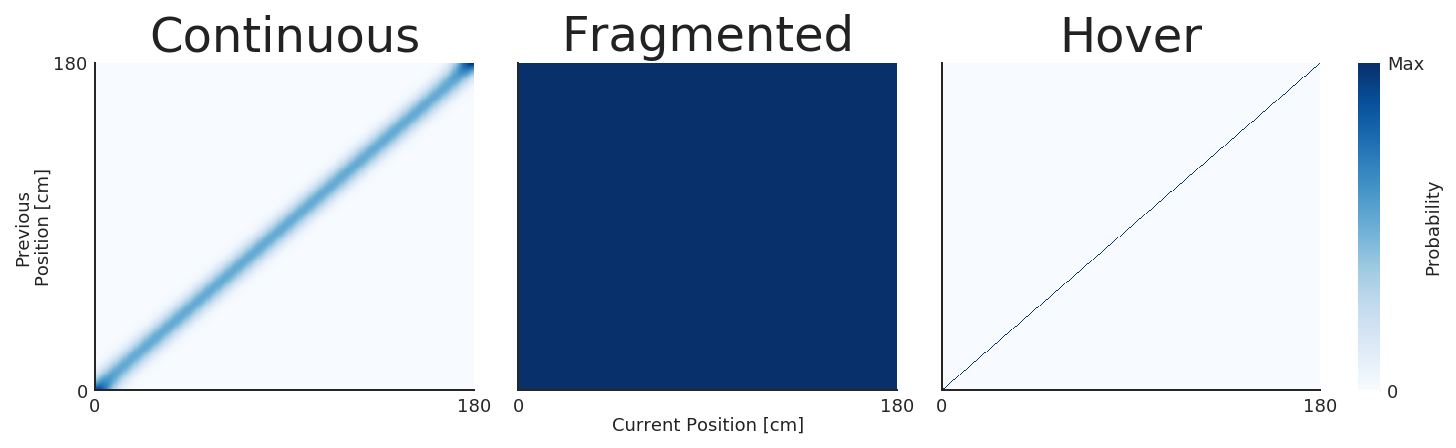

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True, constrained_layout=True)

x, y = np.meshgrid(classifier.place_bin_edges_, classifier.place_bin_edges_)
names = ['Continuous', 'Fragmented', 'Hover']

for k, (ax, name) in enumerate(zip(axes, names)):
    state_transition = classifier.continuous_state_transition_[k, k]
    h = ax.pcolormesh(x, y, state_transition, cmap='Blues',
                      vmin=0.0, vmax=state_transition.max(), rasterized=True)
    ax.set_title(name, fontsize=24)

cbar = fig.colorbar(h, label='Probability', aspect=50, ticks=[0, state_transition.max()])
cbar.ax.set_yticklabels(['0', 'Max'])  # vertically oriented colorbar
cbar.outline.set_visible(False)

axes[-1].set_xticks((linear_distance.min(), linear_distance.max()))
axes[-1].set_yticks((linear_distance.min(), linear_distance.max()))
axes[1].set_xlabel('Current Position [cm]')
axes[0].set_ylabel('Previous\nPosition [cm]')

sns.despine()

([<matplotlib.axis.XTick at 0x7fd85d103940>,
 <a list of 2 Text xticklabel objects>)

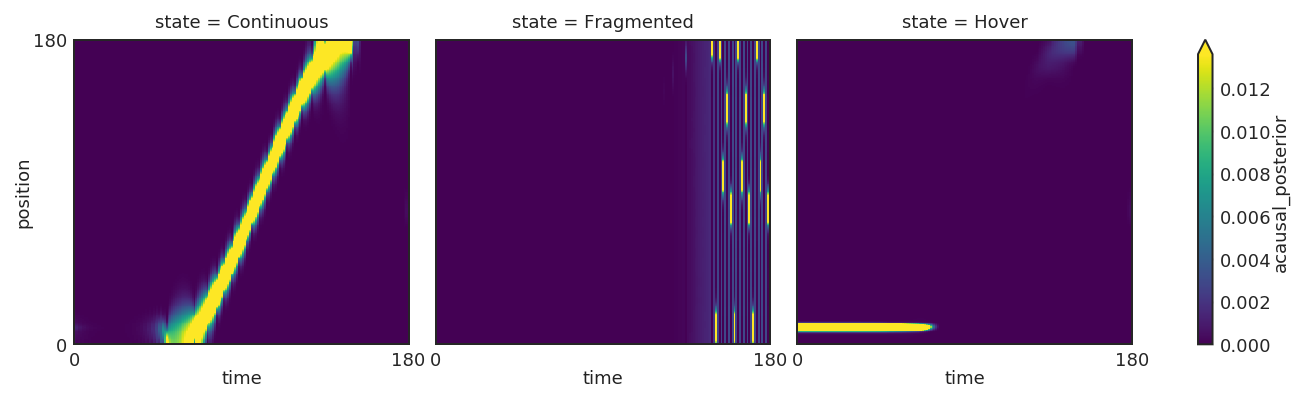

In [72]:
results.acausal_posterior.plot(x='time', y='position', robust=True, vmin=0.0, rasterized=True, col='state')

plt.ylim((linear_distance.min(), linear_distance.max()))
plt.yticks((linear_distance.min(), linear_distance.max()))
plt.xlim((replay_time.min(), replay_time.max() + 1))
plt.xticks((replay_time.min(), replay_time.max() + 1))

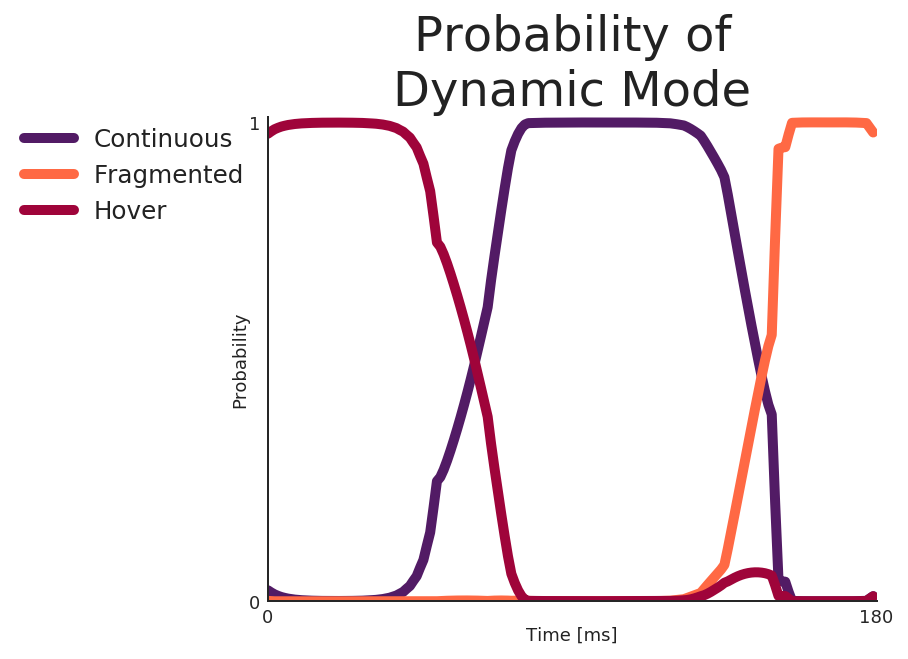

In [145]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 5]})

probabilities = results.acausal_posterior.sum('position').values

for probability, state in zip(probabilities.T, results.state.values):
    axes[1].plot(replay_time, probability, linewidth=5, label=state, color=STATE_COLORS[state])

# ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.05))
h, l = axes[1].get_legend_handles_labels()
axes[0].legend(h, l, loc='upper center', borderaxespad=0.0, frameon=False)
axes[0].axis('off')

axes[1].set_xticks((replay_time.min(), replay_time.max() + 1))
axes[1].set_xlim((replay_time.min(), replay_time.max() + 1))
axes[1].set_xlabel('Time [ms]')
axes[1].set_ylabel('Probability')
axes[1].set_yticks([0, 1])
axes[1].set_ylim([0, 1.01])
axes[1].set_title('Probability of\nDynamic Mode', fontsize=24)
sns.despine()

(0.0, 180.0)

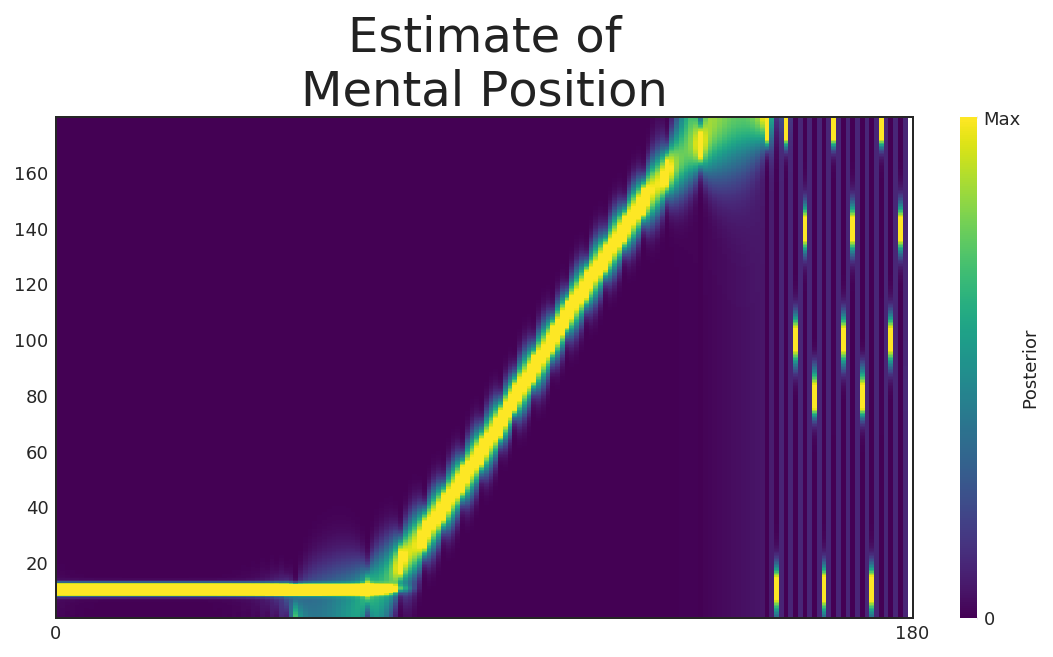

In [106]:
posterior = results.acausal_posterior.sum('state').values.T

x, y = np.meshgrid(results.time, classifier.place_bin_centers_)
fig, ax = plt.subplots(constrained_layout=True)

h = ax.pcolormesh(x, y, posterior, vmin=0.0, vmax=np.percentile(posterior, 97.5), rasterized=True, cmap='viridis')
cbar = fig.colorbar(h, label='Posterior', aspect=50, ticks=[0, np.percentile(posterior, 97.5)])
cbar.ax.set_yticklabels(['0', 'Max'])  # vertically oriented colorbar
cbar.outline.set_visible(False)

ax.set_title('Estimate of\nMental Position', fontsize=24)
plt.xticks((replay_time.min(), replay_time.max() + 1))
plt.xlim((replay_time.min(), replay_time.max() + 1))